<a href="https://colab.research.google.com/github/Senya77/Intern_ML_Task/blob/main/Intern_ML_task_Letunovskiy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорты необходимых библиотек и setup окружения для обучения

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.optim import SGD, Adam

import sklearn
import sklearn.metrics as metrics

import pandas as pd
from tqdm.notebook import tqdm_notebook

import os
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Работа с датасетом и его подготовка для обучения

In [ ]:
transform = Compose([ToTensor(),
                     # нормализация данных
                     # значения из интернета
                    Normalize(mean = [0.4915, 0.4823, 0.4468],
                              std = [0.2470, 0.2435, 0.2616])])


In [ ]:
# загрузка тренировочного, тестового и валидационного наборов данных
train_data = CIFAR10(
    root='cifar',
    train = True,
    download = True,
    transform=transform
)

test_data = CIFAR10(
    root='cifar',
    train = False,
    download = True,
    transform=transform
)

valid_data = CIFAR10(
    root='cifar',
    train = True,
    download = True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:02<00:00, 59029632.59it/s]


Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# разделение выборки на валидационную и тренировочную
# создание даталоадеров

# модели будут обучаться пакетами по 64 изображения
# после чего будут обновлять веса
batch_size = 64
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

np.random.seed(17)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler)

## Подготовка моделей

In [ ]:
# Первая модель - нейронная сеть с одним скрытым слоем.

class NN(nn.Module):
  def __init__(self):
    super(NN, self).__init__()
    self.flatten = nn.Flatten()
    self.linear = nn.Sequential(
        nn.Linear(32*32*3, 1024),
        nn.ReLU(),
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear(x)
    return x

In [ ]:
# Вторая модель - таже самая архитектура, но с батч-нормализацией.
# Батч-нормализация должна усреднять(нормализовать) данные после каждого слоя,
# чтобы модель была более стабильна и быстрее обучалась.

class NNBatch(nn.Module):
  def __init__(self):
    super(NNBatch, self).__init__()
    self.flatten = nn.Flatten()
    self.linear = nn.Sequential(
        nn.Linear(32*32*3, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Linear(256, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear(x)
    return x

In [ ]:
# Третья модель - сверточная нейроная сеть,
# данные сети были специально разработаны, для работы с изображениями

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.linear = nn.Sequential(
            nn.Linear(4*4*64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

In [ ]:
# Четвертая модель - сверточная нейроная сеть с батч-нормализацией

class CNNBatch(nn.Module):
    def __init__(self):
        super(CNNBatch, self).__init__()
        self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.linear = nn.Sequential(
            nn.BatchNorm1d(4*4*64),
            nn.Linear(4*4*64, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

In [ ]:
# Пятая модель - сверточная нейроная сеть с слоями Dropout.
# Dropout - метод борьбы с переобучением.
# Этот слой отключает часть нейронов, тем самым модель учится обобщать данные,
# а не запоминает обучающую выборку

class CNNDropout(nn.Module):
    def __init__(self):
        super(CNNDropout, self).__init__()
        self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.linear = nn.Sequential(
            nn.Linear(4*4*64, 1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

## Написание train-loop-а

In [ ]:
def train(model, optimizer, loss_fn, train_dl, val_dl, epochs, device):
    print(f'Обучается модель: {type(model).__name__}_{type(optimizer).__name__}')

    data = {}
    data['epoch'] = epochs
    data['train_loss'] = []
    data['train_acc'] = []
    data['val_loss'] = []
    data['val_acc'] = []

    start_time_sec = time.time()

    # каждая модель обучается 10 эпох
    for epoch in tqdm_notebook(range(epochs)):

        # Тренировка моделей
        model.train()
        train_loss = 0.0
        y_pred, y_true = np.ndarray([]), np.ndarray([])

        for batch in train_dl:

            optimizer.zero_grad()

            x = batch[0].to(device)
            y = batch[1].to(device)
            pred = model(x)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()

            y_pred = np.concatenate((y_pred, torch.max(pred, 1)[1].cpu().numpy()), axis=None)
            y_true = np.concatenate((y_true, y.cpu().numpy()), axis=None)

            train_loss += loss.data.item() * x.size(0)

        train_acc   = metrics.accuracy_score(np.intc(y_true), np.intc(y_pred))
        train_loss  = train_loss / len(train_dl.dataset)


        # Валидация моделей
        model.eval()
        val_loss       = 0.0
        y_pred, y_true = np.ndarray([]), np.ndarray([])

        for batch in val_dl:

            x = batch[0].to(device)
            y = batch[1].to(device)
            pred = model(x)
            loss = loss_fn(pred, y)

            y_pred = np.concatenate((y_pred, torch.max(pred, 1)[1].cpu().numpy()), axis=None)
            y_true = np.concatenate((y_true, y.cpu().numpy()), axis=None)

            val_loss += loss.data.item() * x.size(0)

        val_acc  = metrics.accuracy_score(np.intc(y_true), np.intc(y_pred))
        val_loss = val_loss / len(val_dl.dataset)

        data['train_loss'].append(train_loss)
        data['val_loss'].append(val_loss)
        data['train_acc'].append(train_acc)
        data['val_acc'].append(val_acc)

    # Конец train-loop-a

    end_time_sec = time.time()
    total_time_sec = end_time_sec - start_time_sec
    data['time'] = total_time_sec

    return data

In [ ]:
def test(model, loss_fn, test_dl, device):

  data = {}

  data['y_true'] = []
  data['y_pred'] = []
  data['accuracy'] = 0
  data['loss'] = 0
  model.eval()

  test_loss = 0.0
  X, Y = np.ndarray([]), np.ndarray([])

  for batch in test_dl:
    x = batch[0].to(device)
    y = batch[1].to(device)
    pred = model(x)
    loss = loss_fn(pred, y)

    X = np.concatenate((X, torch.max(pred, 1)[1].cpu().numpy()), axis=None)
    Y = np.concatenate((Y, y.cpu().numpy()), axis=None)

    test_loss += loss.data.item() * x.size(0)

  data['y_true'] = np.intc(Y)
  data['y_pred'] = np.intc(X)
  data['accuracy'] = metrics.accuracy_score(data['y_true'], data['y_pred'])
  data['loss'] = test_loss / len(test_dl.dataset)

  return data


In [ ]:
# функция, запускающая обучение заданных моделей с заданными оптимизаторами

def run_train(models, optimizers, loss_fn, train_dl, val_dl, epochs, device):
  c = 0
  trained_models = {}
  for model in models:
    for optimizer in optimizers:
      mod = model().to(device)
      optim = optimizer(mod.parameters(), lr=0.001)
      trained_models[f'{model.__name__}_{optimizer.__name__}'] = [mod, train(mod, optim, loss_fn, train_dl, val_dl, epochs, device)]
      c += 1
      print(f'Обучено {c} из {len(models) * len(optimizers)}')

  # вовращает словарь вида {название_модели: [модель, {словарь с данными об обучении из функции train}]}
  return trained_models

In [ ]:
# функция, запускающая тестирование заданных моделей

def run_test(trained_models, loss_fn, test_dl, device):
  for model in trained_models:
    trained_models[model].append(test(trained_models[model][0], loss_fn, test_dl, device))

  # добавляет в словарь из предыдущей фукции, данные о тестировании из функции test
  # {название_модели: [модель, {словарь из функции train}, {словарь из функции test}]}
  return trained_models

## Валидация моделей

In [ ]:
models = [NN, NNBatch, CNN, CNNBatch, CNNDropout]
optimizers = [SGD, Adam]
loss_fn = nn.CrossEntropyLoss()
trained_models = run_train(models, optimizers, loss_fn, train_dataloader, valid_dataloader, 10, device)

Обучается модель: NN_SGD


  0%|          | 0/10 [00:00<?, ?it/s]

Обучено 1 из 10
Обучается модель: NN_Adam


  0%|          | 0/10 [00:00<?, ?it/s]

Обучено 2 из 10
Обучается модель: NNBatch_SGD


  0%|          | 0/10 [00:00<?, ?it/s]

Обучено 3 из 10
Обучается модель: NNBatch_Adam


  0%|          | 0/10 [00:00<?, ?it/s]

Обучено 4 из 10
Обучается модель: CNN_SGD


  0%|          | 0/10 [00:00<?, ?it/s]

Обучено 5 из 10
Обучается модель: CNN_Adam


  0%|          | 0/10 [00:00<?, ?it/s]

Обучено 6 из 10
Обучается модель: CNNBatch_SGD


  0%|          | 0/10 [00:00<?, ?it/s]

Обучено 7 из 10
Обучается модель: CNNBatch_Adam


  0%|          | 0/10 [00:00<?, ?it/s]

Обучено 8 из 10
Обучается модель: CNNDropout_SGD


  0%|          | 0/10 [00:00<?, ?it/s]

Обучено 9 из 10
Обучается модель: CNNDropout_Adam


  0%|          | 0/10 [00:00<?, ?it/s]

Обучено 10 из 10


In [ ]:
trained_models = run_test(trained_models, loss_fn, test_dataloader, device)

## Выводы по проделанным экспериментам

### Таблица сравнения сравнения точности различных моделей и оптимизаторов на тестовой выборке.

In [ ]:
# создание датафрейма из словаря вида {модель:{оптимизатор:точность,}, }
# основная меткика - точность, то есть доля правильных ответов
table = {}
for model in models:
  opt = dict.fromkeys([optimizer.__name__ for optimizer in optimizers], 0)
  for optimizer in optimizers:
    name = f'{model.__name__}_{optimizer.__name__}'
    opt[optimizer.__name__] = (round(trained_models[name][2]['accuracy'], 2))
    table[model.__name__] = opt
df = pd.DataFrame.from_dict(table, orient='index')
df

,SGD,Adam
NN,0.42,0.52
NNBatch,0.52,0.54
CNN,0.15,0.74
CNNBatch,0.64,0.73
CNNDropout,0.18,0.74


Сравнивая два оптимизатора, можно сделать вывод, что Adam является более эффективным как для обычной нейронной сети, так и для сверточной нейронной сети.

Значительный прирост точности дало добавление сверточных слоев в нейронную сеть. С оптимизатором Adam точность увеличилась примерно на 45%.

Батч-нормализация сыграла значительную роль в увеличении точности в случае с обычным стохастическим градиентным спуском. В то время как обычная CNN модель и CNN модель с дропаутом показывают плохие результаты точности. Архитектура с батч-нормализацией показывает результаты в 3 раза лучше.

В случае с оптимизатором Adam, Батч-нормализация и дропаут не внесли особы вклад в изменение точности, по сравнению с обычной CNN моделью.

### Графики сравнения тренировочных и валидационных данных

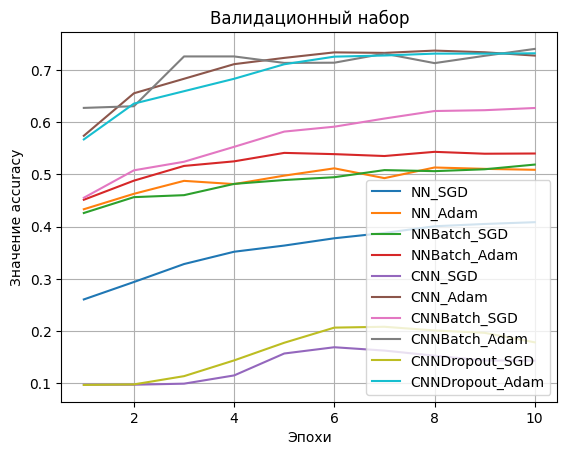

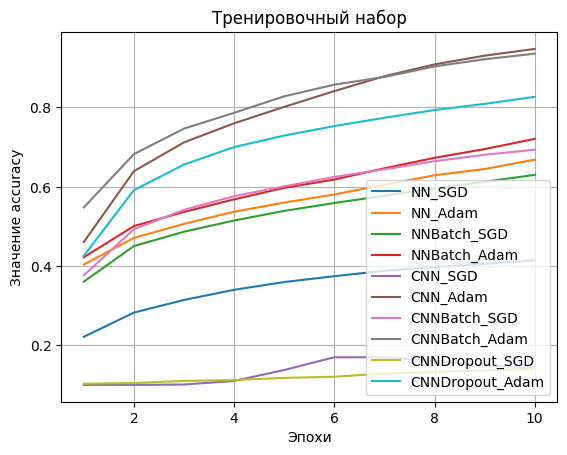

In [ ]:
x = np.arange(1, 11)
for model in trained_models:
  plt.figure(1)
  plt.plot(x, trained_models[model][1]['val_acc'])
  plt.figure(2)
  plt.plot(x, trained_models[model][1]['train_acc'])

plt.figure(1)
plt.title('Валидационный набор')
plt.xlabel('Эпохи')
plt.ylabel('Значение accuracy')
plt.legend([name for name in trained_models])
plt.grid(True)

plt.figure(2)
plt.title('Тренировочный набор')
plt.xlabel('Эпохи')
plt.ylabel('Значение accuracy')
plt.legend([name for name in trained_models])
plt.grid(True)
plt.show()

### Попарное сравнение валидационных и тренировочных данных

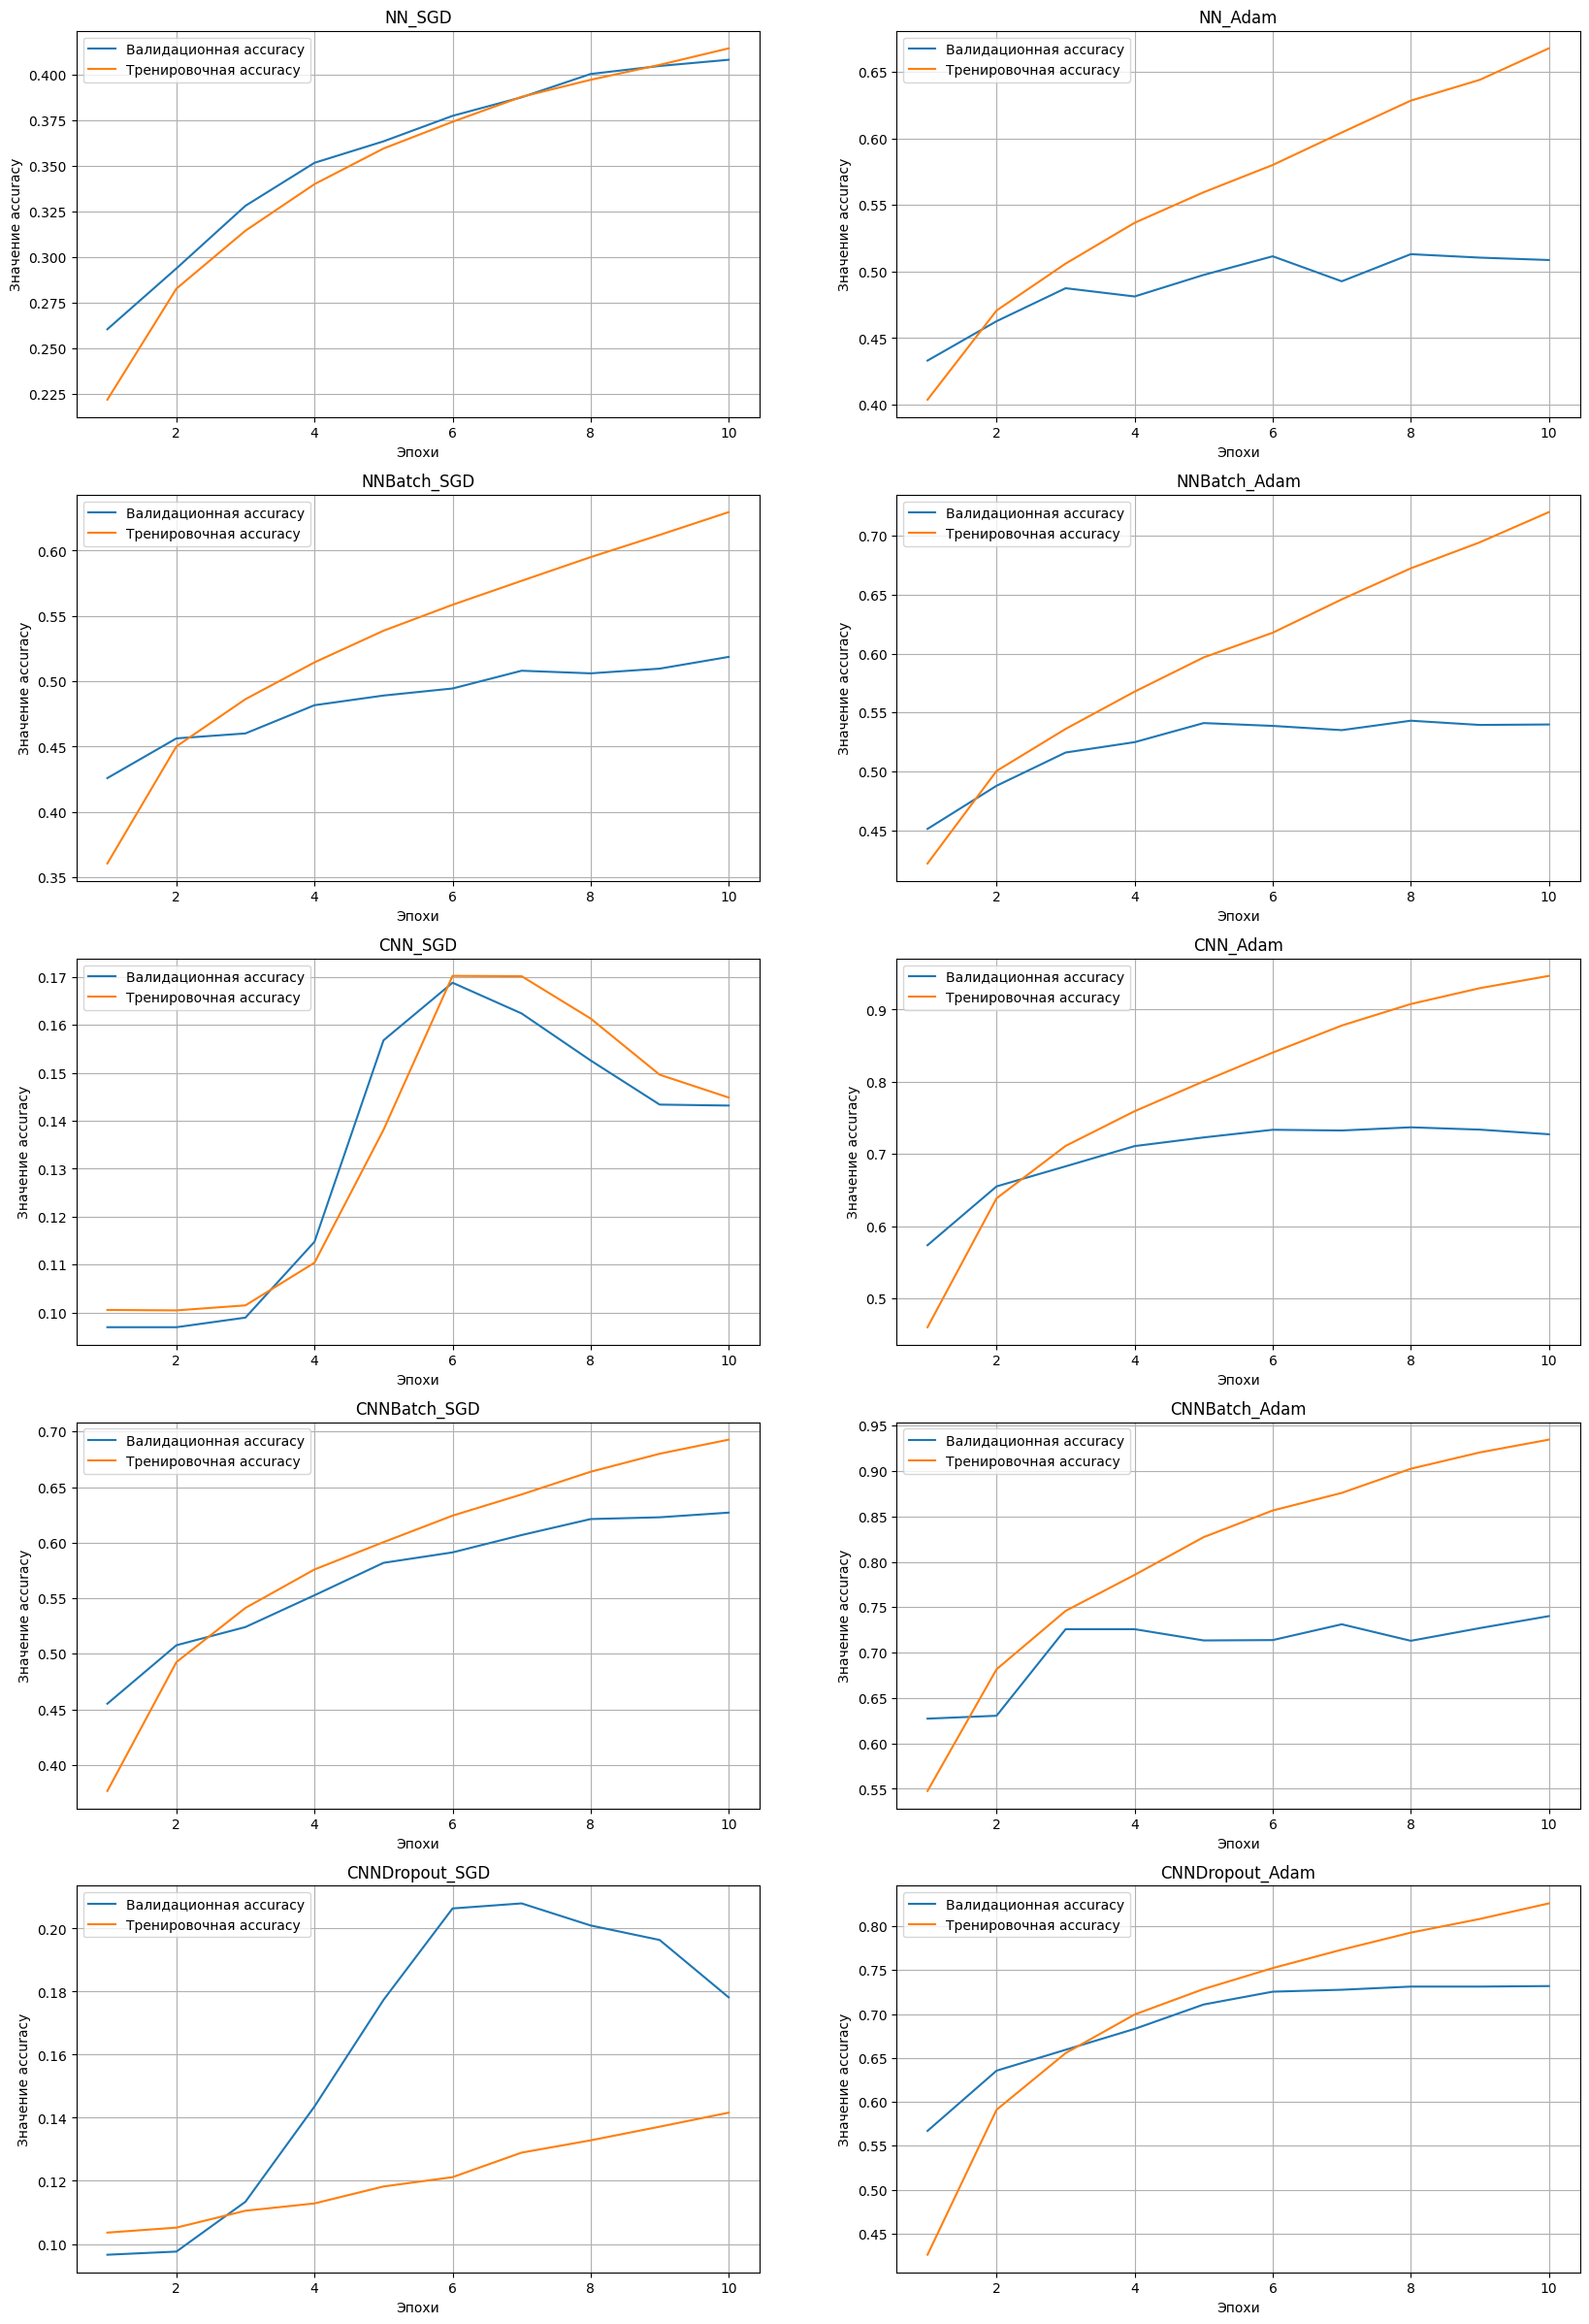

In [ ]:
x = np.arange(1, 11)
i = 1
figure = plt.figure(figsize=(20, 30))
for model in trained_models:
  figure.add_subplot(5, 2, i)
  plt.title(model)
  plt.plot(x, trained_models[model][1]['val_acc'])
  plt.plot(x, trained_models[model][1]['train_acc'])
  plt.xlabel('Эпохи')
  plt.ylabel('Значение accuracy')
  plt.legend(['Валидационная accuracy', 'Тренировочная accuracy'])
  plt.grid(True)
  i += 1
plt.show()

### Таблица сравнения разницы тренировочной точности и тестовой

In [ ]:
table = {}
for model in models:
  opt = dict.fromkeys([optimizer.__name__ for optimizer in optimizers], 0)
  for optimizer in optimizers:
    name = f'{model.__name__}_{optimizer.__name__}'
    opt[optimizer.__name__] = (round(trained_models[name][1]['train_acc'][9], 2) - round(trained_models[name][2]['accuracy'], 2))
    table[model.__name__] = opt
diff = pd.DataFrame.from_dict(table, orient='index')
diff

,SGD,Adam
NN,-0.01,0.15
NNBatch,0.11,0.18
CNN,-0.01,0.21
CNNBatch,0.05,0.20
CNNDropout,-0.04,0.09


Практически во всех моделях присутствует переобучение, особенно в тех, что показывают большую точность.

Исходя из таблицы, можно сделать вывод, что выключение примерно половины нейронов (метод Dropout) довольно сильно сказалось на переобучении модели (в случае с оптимизатором Adam). Несмотря на то, что сеть с Dropout слоями показала такие же результаты как сеть без них и с Батч-нормализацией, разница в точности обучающей и тестовой выборки стала больше чем в два раза меньше.

### Сравнение моделей по качеству распознования отдельных классов.

In [ ]:
x = np.arange(1, 11)
c = 1
for model in trained_models:
  a = metrics.classification_report(trained_models[model][2]['y_true'], trained_models[model][2]['y_pred'],
                                    target_names = test_dataloader.dataset.classes)
  print(model)
  print(a)
  print('-------------------------------------------- \n')


NN_SGD
              precision    recall  f1-score   support

    airplane       0.50      0.46      0.48      1001
  automobile       0.45      0.51      0.48      1000
        bird       0.36      0.23      0.28      1000
         cat       0.33      0.24      0.28      1000
        deer       0.39      0.32      0.35      1000
         dog       0.38      0.40      0.39      1000
        frog       0.42      0.53      0.47      1000
       horse       0.44      0.45      0.44      1000
        ship       0.49      0.56      0.53      1000
       truck       0.43      0.54      0.48      1000

    accuracy                           0.42     10001
   macro avg       0.42      0.42      0.42     10001
weighted avg       0.42      0.42      0.42     10001

-------------------------------------------- 

NN_Adam
              precision    recall  f1-score   support

    airplane       0.57      0.57      0.57      1001
  automobile       0.62      0.67      0.64      1000
        bird    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Исходя из таблиц classification report наиболее точно модели определяют разного рода тезнику: корабли, автомобили, самолеты и грузовики и не так хорошо живых существ (разве что лошади и лягушки немного выделяются более точными предсказаниями).

На примере одной из архитектур, можно посмотреть как модель классифицирует изображения.

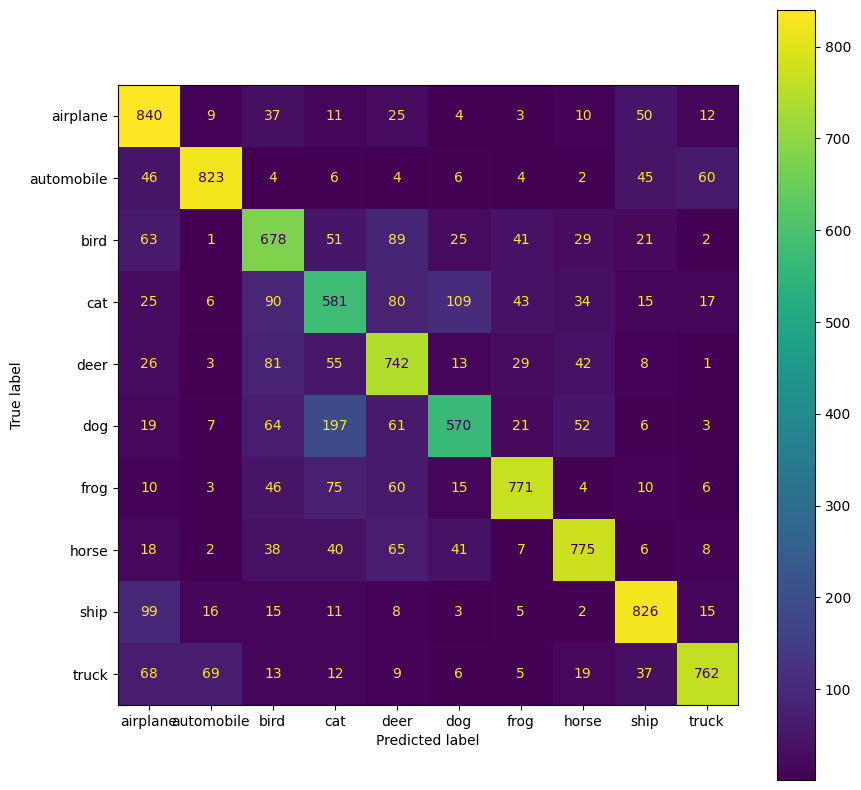

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
cm = metrics.confusion_matrix(trained_models['CNN_Adam'][2]['y_true'], trained_models['CNN_Adam'][2]['y_pred'])
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels = test_dataloader.dataset.classes)
cmd.plot(ax=ax)

Чаще всего модель путает кошек с собаками и наоборот. Так же из матрицы видно, что нейросеть в принципе путает животных между собой примерно одинаково. Кроме того есть небольшая путаница между самолетами и короблями и грузовиками и автомобилями.